# Проект [SF-DST Car Price prediction] Прогнозирование стоимости автомобиля по характеристикам

## Импорт библиотек

In [38]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# # InteractiveShell.ast_node_interactivity = "last_expr"

In [39]:
import requests
# from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor

from sklearn import metrics  # инструменты для оценки точности модели

In [40]:
RANDOM_SEED = 42
random_state = RANDOM_SEED

# Setup

In [41]:
DIR_TRAIN  = '../input/train-data-autoru/' # подключил к ноутбуку свой внешний датасет
DIR_TEST   = '../input/sf-dst-car-price/'
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

In [42]:
def get_boxplot(df, column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='price', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [43]:
def heat_map(df_bool):
    fig, ax = plt.subplots(figsize=(20, 12))
    sns_heatmap = sns.heatmap(df_bool, yticklabels=False, cbar=False, cmap='viridis')

## Чтение данных

In [44]:
df_train = pd.read_csv(DIR_TRAIN + 'train.csv.gzip', compression='gzip')
df_test = pd.read_csv(DIR_TEST + 'test.csv')
sample_submission = pd.read_csv(DIR_TEST + 'sample_submission.csv')

## Данные для обучения

Данные получены с сайта auto.ru с помощью https://github.com/kopagm/skillfactory_rds/tree/master/module_6/utils/autoru

### Предобработка данных для обучения

Отбрасываем дубликаты и строки с пропущенной ценой.

In [45]:
df_train = df_train.drop_duplicates()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3295 entries, 0 to 3634
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3295 non-null   object 
 1   brand                 3295 non-null   object 
 2   color                 3295 non-null   object 
 3   fuelType              3295 non-null   object 
 4   modelDate             3295 non-null   int64  
 5   name                  3295 non-null   object 
 6   numberOfDoors         3295 non-null   int64  
 7   productionDate        3295 non-null   int64  
 8   vehicleConfiguration  3295 non-null   object 
 9   vehicleTransmission   3295 non-null   object 
 10  engineDisplacement    3295 non-null   object 
 11  enginePower           3295 non-null   object 
 12  description           3294 non-null   object 
 13  mileage               3294 non-null   float64
 14  Комплектация          3294 non-null   object 
 15  Привод               

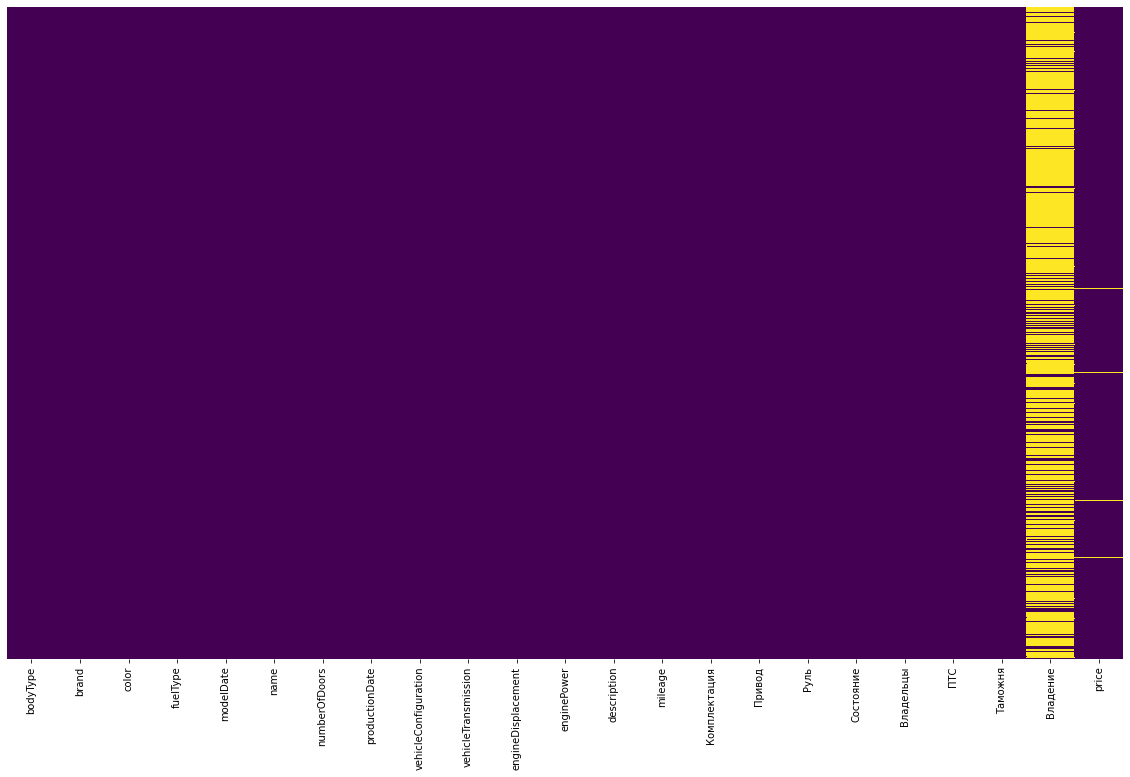

In [46]:
heat_map(df_train.isna())

In [47]:
df_train = df_train.dropna(subset=['price'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3279 entries, 0 to 3634
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3279 non-null   object 
 1   brand                 3279 non-null   object 
 2   color                 3279 non-null   object 
 3   fuelType              3279 non-null   object 
 4   modelDate             3279 non-null   int64  
 5   name                  3279 non-null   object 
 6   numberOfDoors         3279 non-null   int64  
 7   productionDate        3279 non-null   int64  
 8   vehicleConfiguration  3279 non-null   object 
 9   vehicleTransmission   3279 non-null   object 
 10  engineDisplacement    3279 non-null   object 
 11  enginePower           3279 non-null   object 
 12  description           3279 non-null   object 
 13  mileage               3279 non-null   float64
 14  Комплектация          3279 non-null   object 
 15  Привод               

Пропуски остались только в "Владение"

## Объединение тренировочной выборки и выборки для предсказания

In [48]:
df_train = df_train.convert_dtypes()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3279 entries, 0 to 3634
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              3279 non-null   string
 1   brand                 3279 non-null   string
 2   color                 3279 non-null   string
 3   fuelType              3279 non-null   string
 4   modelDate             3279 non-null   Int64 
 5   name                  3279 non-null   string
 6   numberOfDoors         3279 non-null   Int64 
 7   productionDate        3279 non-null   Int64 
 8   vehicleConfiguration  3279 non-null   string
 9   vehicleTransmission   3279 non-null   string
 10  engineDisplacement    3279 non-null   string
 11  enginePower           3279 non-null   string
 12  description           3279 non-null   string
 13  mileage               3279 non-null   Int64 
 14  Комплектация          3279 non-null   string
 15  Привод                3279 non-null   

In [49]:
df_test = df_test.convert_dtypes()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              3837 non-null   string
 1   brand                 3837 non-null   string
 2   color                 3837 non-null   string
 3   fuelType              3837 non-null   string
 4   modelDate             3837 non-null   Int64 
 5   name                  3837 non-null   string
 6   numberOfDoors         3837 non-null   Int64 
 7   productionDate        3837 non-null   Int64 
 8   vehicleConfiguration  3837 non-null   string
 9   vehicleTransmission   3837 non-null   string
 10  engineDisplacement    3837 non-null   string
 11  enginePower           3837 non-null   string
 12  description           3837 non-null   string
 13  mileage               3837 non-null   Int64 
 14  Комплектация          3837 non-null   string
 15  Привод                3837 non-null   

In [52]:
# ВАЖНО! дряastypeректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['price'] = 0 #

df = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7116 entries, 0 to 7115
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              7116 non-null   string
 1   brand                 7116 non-null   string
 2   color                 7116 non-null   string
 3   fuelType              7116 non-null   string
 4   modelDate             7116 non-null   Int64 
 5   name                  7116 non-null   string
 6   numberOfDoors         7116 non-null   Int64 
 7   productionDate        7116 non-null   Int64 
 8   vehicleConfiguration  7116 non-null   string
 9   vehicleTransmission   7116 non-null   string
 10  engineDisplacement    7116 non-null   string
 11  enginePower           7116 non-null   string
 12  description           7116 non-null   string
 13  mileage               7116 non-null   Int64 
 14  Комплектация          7116 non-null   string
 15  Привод                7116 non-null   

## Предобработка

### Пропуски

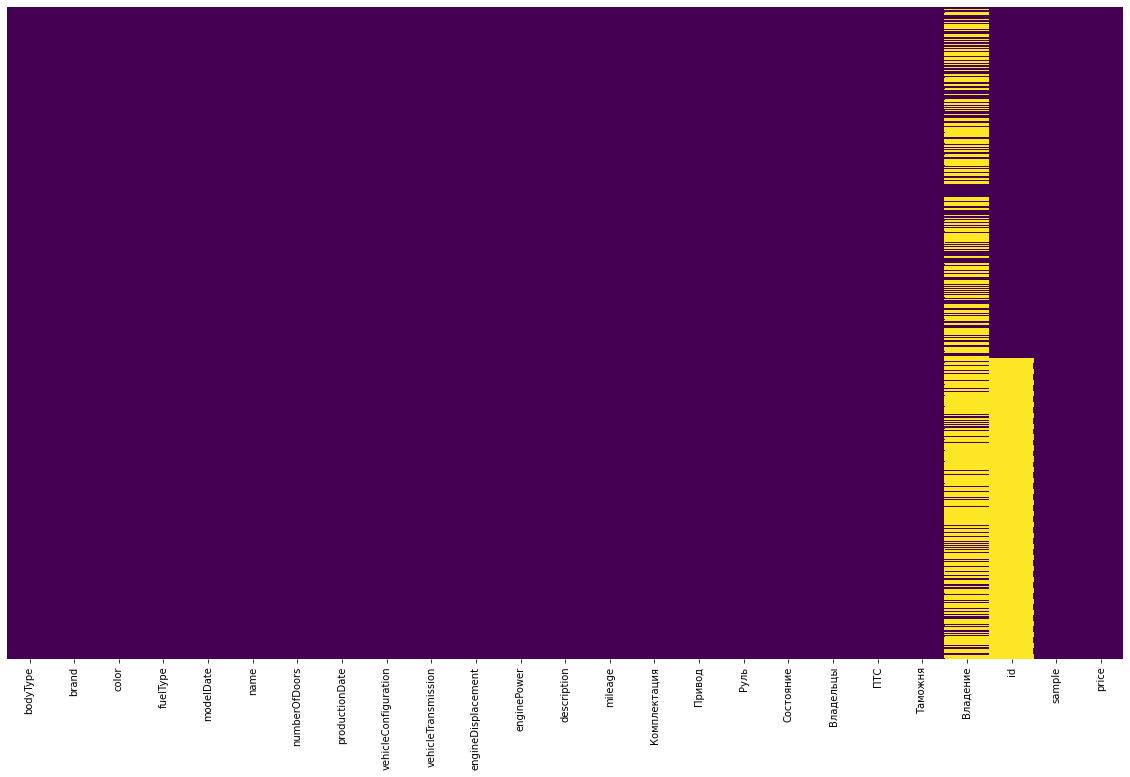

In [54]:
heat_map(df.isna())

Пропуски только в "Владение" и в "id" для тренировочной выборки. "id" не несет информации и не понадобится.

In [55]:
df.nunique()

bodyType                  11
brand                      1
color                     15
fuelType                   4
modelDate                 38
name                     862
numberOfDoors              4
productionDate            45
vehicleConfiguration     130
vehicleTransmission        3
engineDisplacement        33
enginePower               86
description             6489
mileage                 2908
Комплектация            3303
Привод                     6
Руль                       2
Состояние                  1
Владельцы                  4
ПТС                        2
Таможня                    1
Владение                 167
id                      3837
sample                     2
price                   1521
dtype: int64

### Преобразования значений и переименование полей

In [56]:
def preproc_data(df_input):
    def string_to_float(a):
        try:
            return float(a)
        except ValueError:
            return None

    def get_list_from_equip(eqips):
        result = []
        for eq in eqips:
            result += eq['values']
        return result

    df = df_input.copy()
    df['enginePower'] = df['enginePower'].apply(lambda x: str.split(x)[0])
    
    df.loc[df['sample'] == 0,
           'equip'] = df.loc[df['sample'] == 0,
                             'Комплектация'].apply(lambda x: json.loads(str.replace(x, "\'", '')))
    df.loc[df['sample'] == 1,
           'equip'] = df.loc[df['sample'] == 1,
                             'Комплектация'].apply(lambda x: json.loads(str.replace(x, "'", '"')))
    # преведение к единому виду с train
    df.loc[df['sample'] == 0, 'equip'] = df.loc[df['sample'] == 0,
                                                'equip'].apply(lambda x: x[0] if len(x) else [])
    df['equip'] = df['equip'].apply(get_list_from_equip)
    
    df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: str.split(x)[0])
    df['engineDispl'] = df['engineDisplacement'].apply(string_to_float)
    df.drop(columns=['engineDisplacement'])
    df['Привод'] = df['Привод'].str.lower()
    df['Владельцы'] = df['Владельцы'].apply(lambda x: str.split(x)[0])

    df['price'] = df['price'].apply(lambda x: np.int(x))

    # drop columns
    df.drop(columns=['engineDisplacement', 'Комплектация', 'id', 'Состояние'], inplace=True)
    # fill na
    df['engineDispl'].fillna(df['engineDispl'].mean())
    return df

In [57]:
df = preproc_data(df)

In [58]:
columns = df.columns
df.loc[0:5,columns[:]]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Привод,Руль,Владельцы,ПТС,Таможня,Владение,sample,price,equip,engineDispl
0,седан,BMW,чёрный,дизель,2016,520d 2.0d AT (190 л.с.),4,2017,SEDAN AUTOMATIC 2.0,автоматическая,...,задний,Левый,1,Оригинал,Растаможен,<NA>,0,0,"[Антипробуксовочная система (ASR), Система ста...",2.0
1,седан,BMW,белый,дизель,2018,318d 2.0d AT (150 л.с.),4,2019,SEDAN AUTOMATIC 2.0,автоматическая,...,задний,Левый,1,Оригинал,Растаможен,<NA>,0,0,"[Круиз-контроль, Мультифункциональное рулевое ...",2.0
2,седан,BMW,синий,бензин,2009,550i xDrive 4.4 AT (407 л.с.) 4WD,4,2012,SEDAN AUTOMATIC 4.4,автоматическая,...,полный,Левый,2,Оригинал,Растаможен,7 лет и 2 месяца,0,0,"[Круиз-контроль, Мультифункциональное рулевое ...",4.4
3,внедорожник 5 дв.,BMW,белый,дизель,2014,30d 3.0d AT (249 л.с.) 4WD,5,2015,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,...,полный,Левый,2,Оригинал,Растаможен,<NA>,0,0,"[Круиз-контроль, Система «старт-стоп», Электро...",3.0
4,внедорожник 5 дв.,BMW,синий,дизель,2014,M50d 3.0d AT (381 л.с.) 4WD,5,2019,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,...,полный,Левый,1,Оригинал,Растаможен,<NA>,0,0,"[Круиз-контроль, Электрорегулировка руля, Муль...",3.0
5,внедорожник 5 дв.,BMW,коричневый,дизель,2013,30d 3.0d AT (249 л.с.) 4WD,5,2013,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,...,полный,Левый,2,Дубликат,Растаможен,<NA>,0,0,[],3.0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7116 entries, 0 to 7115
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              7116 non-null   string 
 1   brand                 7116 non-null   string 
 2   color                 7116 non-null   string 
 3   fuelType              7116 non-null   string 
 4   modelDate             7116 non-null   Int64  
 5   name                  7116 non-null   string 
 6   numberOfDoors         7116 non-null   Int64  
 7   productionDate        7116 non-null   Int64  
 8   vehicleConfiguration  7116 non-null   string 
 9   vehicleTransmission   7116 non-null   string 
 10  enginePower           7116 non-null   object 
 11  description           7116 non-null   string 
 12  mileage               7116 non-null   Int64  
 13  Привод                7116 non-null   string 
 14  Руль                  7116 non-null   string 
 15  Владельцы            

## Классификация параметров

In [60]:
columns = df.columns

In [61]:
bin_cols = ['Руль', 'ПТС']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'enginePower',
       'Привод', 'Владельцы', 'Таможня', 'Владение', 'engineDispl']
num_cols = ['mileage', 'price']


## Визуализация параметров

### Категориальные

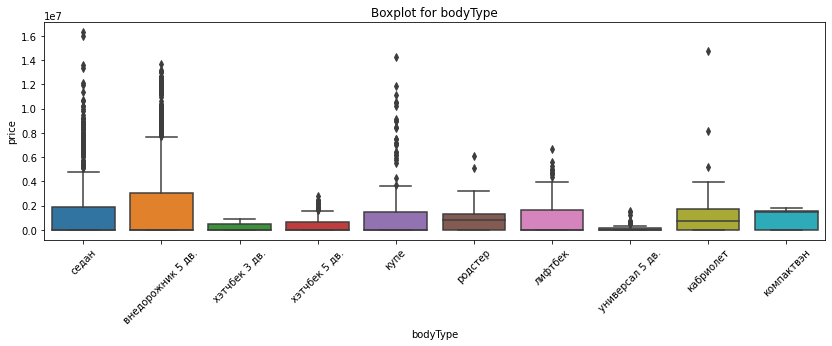

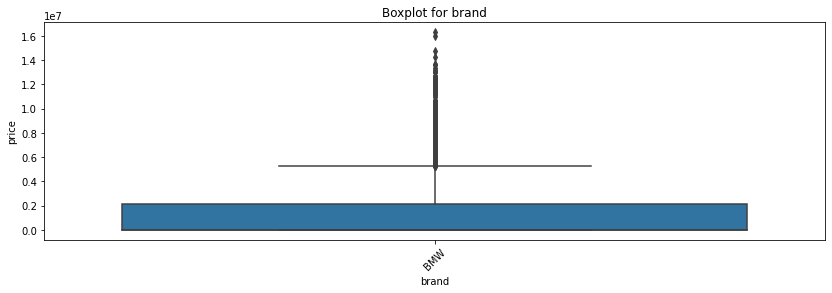

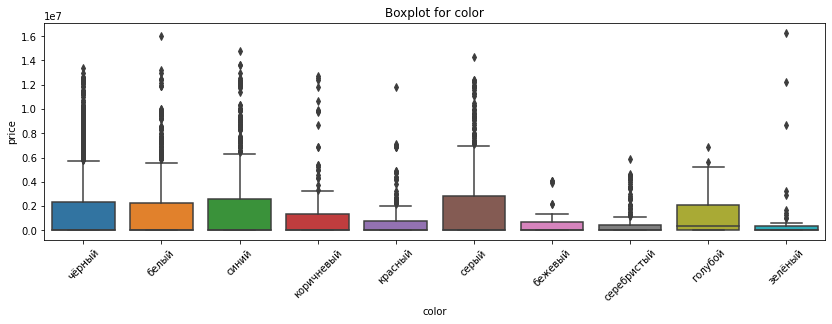

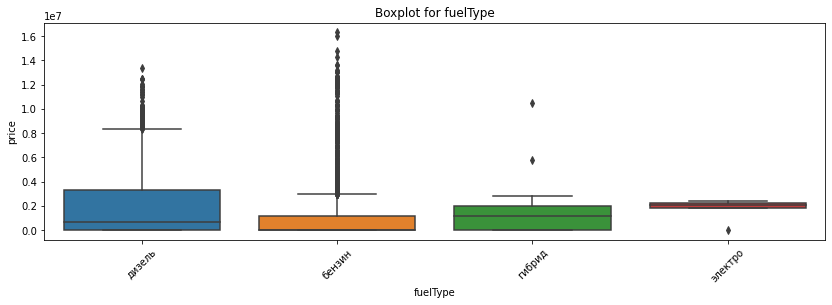

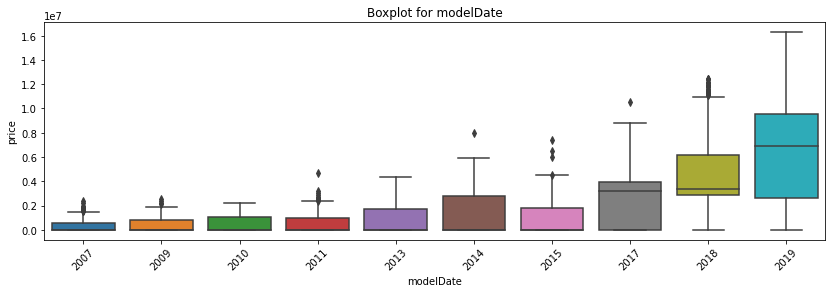

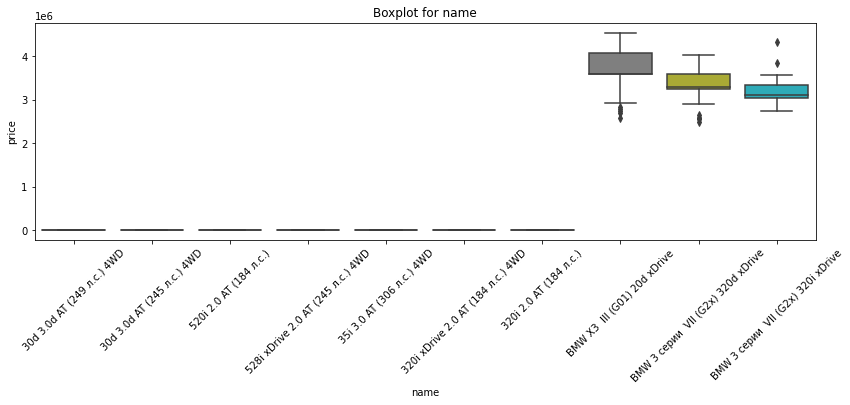

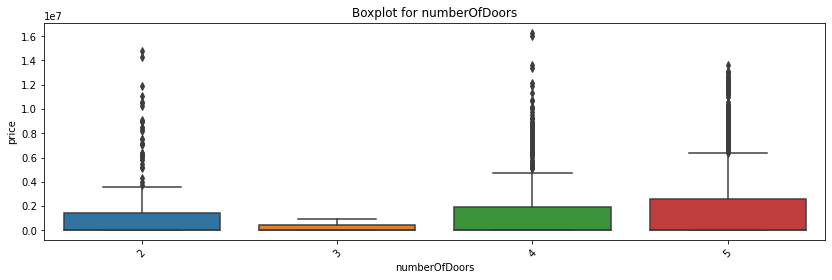

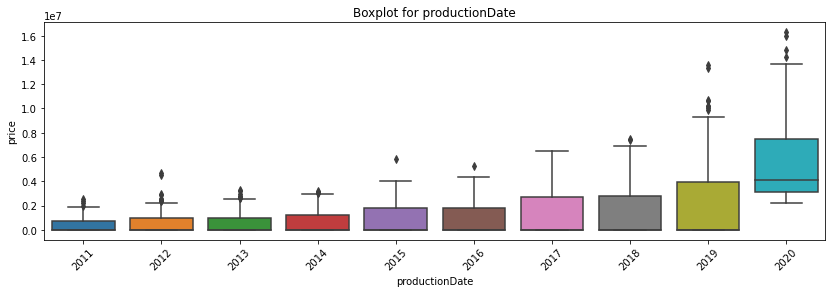

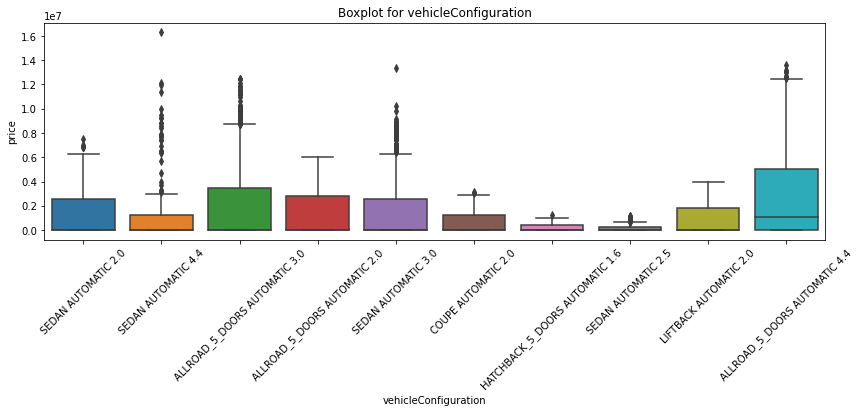

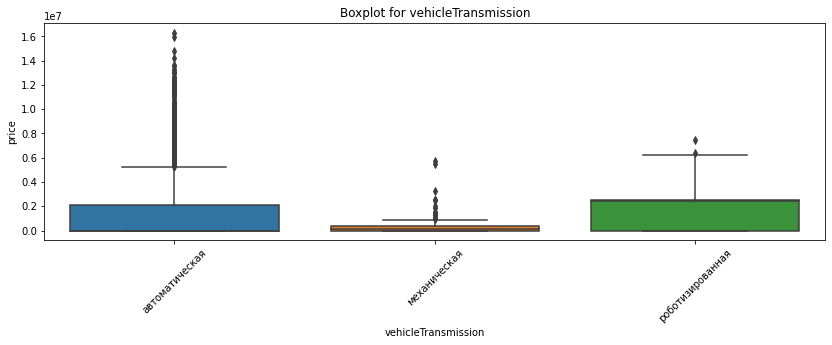

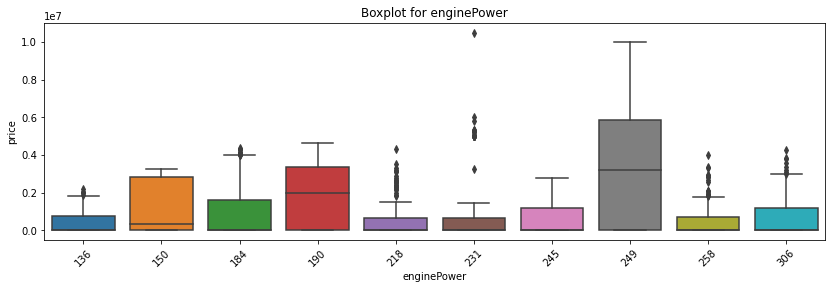

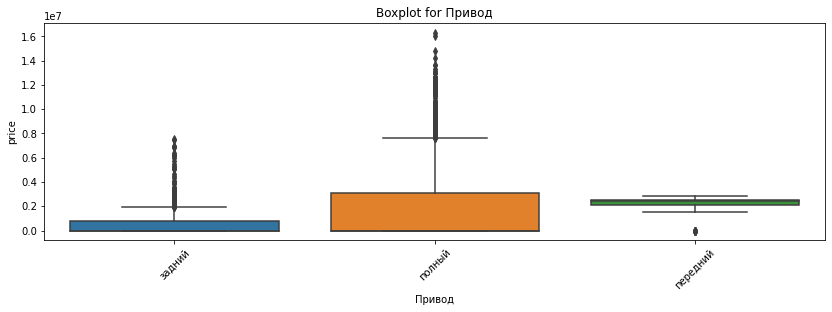

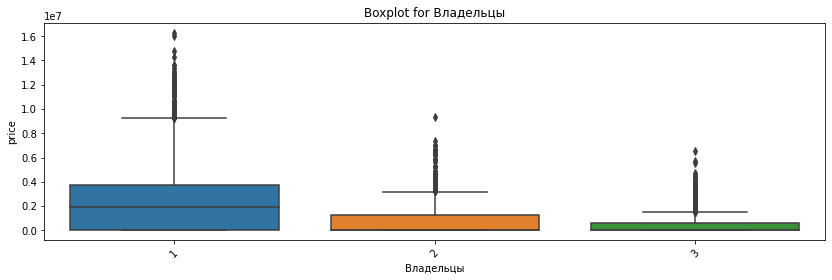

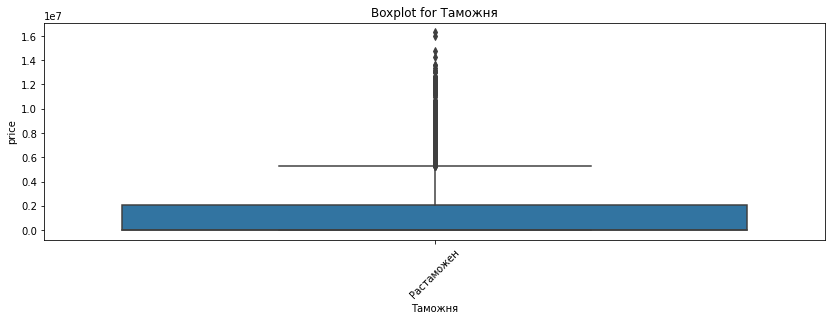

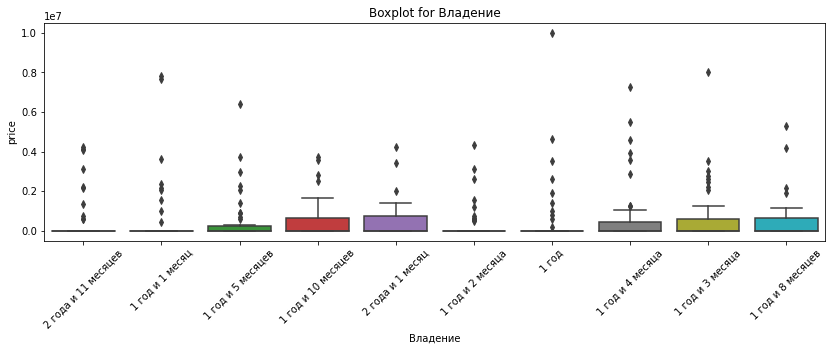

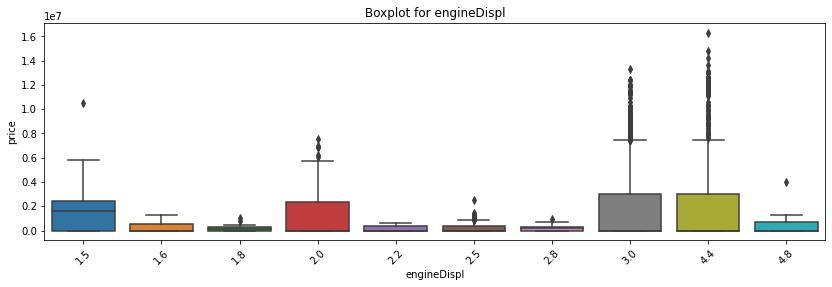

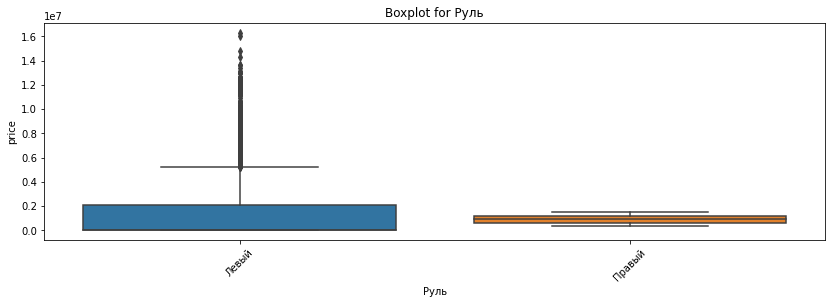

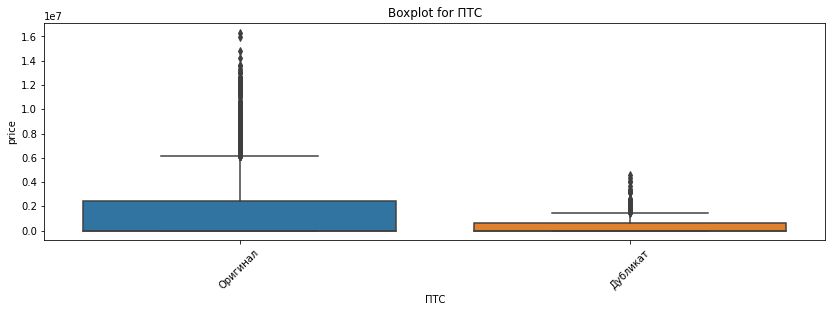

In [62]:
for col in cat_cols+bin_cols:
#     get_boxplot(df[df['sample'] == 1], col)
    get_boxplot(df, col)

Часто встречающиеся значения "name" присутсвуют в тесте, но отсутствуют в трейне (отсутствует цена на диаграмме).

### Числовые

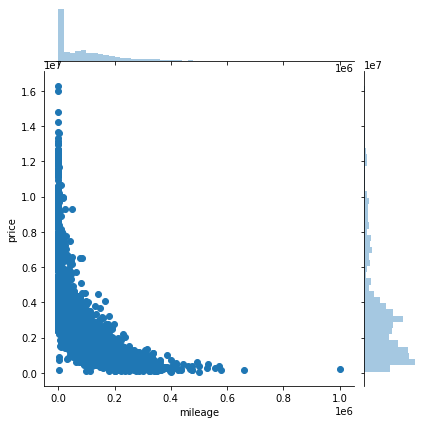

In [63]:
sns.jointplot(x='mileage', y='price', data=df_train)

In [64]:
df[num_cols].describe()

,mileage,price
count,7116.000000,7.116000e+03
mean,104075.829539,1.414472e+06
std,93260.454510,2.394195e+06
min,0.000000,0.000000e+00
25%,25000.000000,0.000000e+00
50%,92020.000000,0.000000e+00
75%,153856.250000,2.099250e+06
max,1000000.000000,1.629000e+07


In [65]:
def get_boxplot_single(df, column):
    fig, ax = plt.subplots()
    sns.boxplot(y=column, 
                data=df,
               ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [66]:
def get_hist(df, column):
    fig, ax = plt.subplots()
    df[column].plot.hist()
    ax.set_title('Histogram for ' + column)
    plt.show()

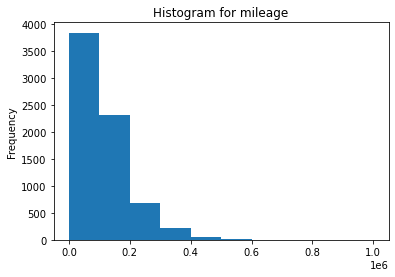

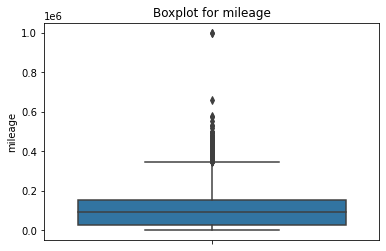

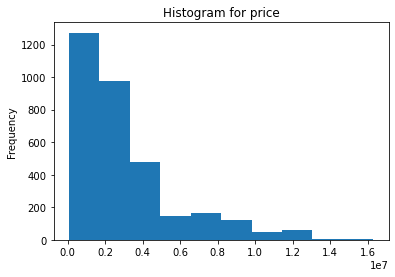

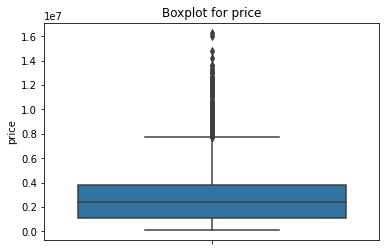

In [67]:
for col in num_cols:
    if col == 'price':
        df_g = df.loc[df['sample'] == 1]
    else:
        df_g = df
    get_hist(df_g, col)
    get_boxplot_single(df_g, col)

Распределения имеют выбросы и длинные хвосты с права.

In [68]:
df.loc[df['mileage'] > 5e5, ['mileage', 'price', 'sample']]

,mileage,price,sample
1228,1000000,0,0
3713,520416,0,0
4722,577602,135000,1
5555,555555,250000,1
6463,531000,520000,1
6687,1000000,200000,1
6710,530000,280000,1
6730,573000,400000,1
6944,659636,140000,1


Можно попробовать и с удалением выбросов 'mileage' и с ними. Пока оставим все значения.

## Создание новых параметров

### Новые параметры на основании комплектаций (equip)

Создадим новые параметры из спсиков параметра 'equip'

In [69]:
def get_equip_features(df):
    def get_equips(df):
        res = set()
        for eq in df['equip']:
            res.update(set(eq))
        return res
    
    def get_equips(df):
        res = set()
        for eq in df['equip']:
            res.update(set(eq))
        return res
    
    for feature in get_equips(df):
        df['eq_'+feature] = df['equip'].apply(lambda x: 1 if feature in x else 0)

In [70]:
get_equip_features(df)

In [71]:
df.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission',
       ...
       'eq_Электрообогрев зоны стеклоочистителей', 'eq_Количество мест: 4',
       'eq_Электрорегулировка сиденья водителя', 'eq_Количество мест: 7',
       'eq_Бронированный кузов', 'eq_Климат-контроль 1-зонный',
       'eq_Лазерные фары', 'eq_Аудиосистема Hi-Fi',
       'eq_Датчик проникновения в салон (датчик объема)',
       'eq_Открытие багажника без помощи рук'],
      dtype='object', length=192)

### brand 

Пока в выборке только один бренд - удаляем.

### vehicleConfiguration 

vehicleConfiguration 
повторяет информцию из других параметров. Удалим
<!-- Выберем 10 наиболее частых и остальные объединим. -->

### name 

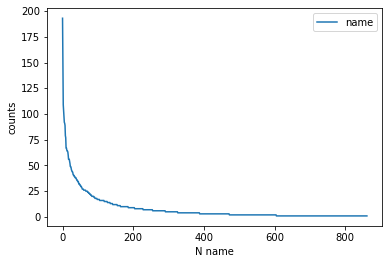

In [72]:
a = df.name.value_counts().values
pd.DataFrame(a, columns=['name']).plot(xlabel='N name', ylabel='counts')

In [73]:
def label_top_values(df, col, n):
    top_values = list(df[col].value_counts().head(n).index)
    return df[col].apply(lambda x: x if x in top_values else 'other')

In [74]:
label_top_values(df, 'name', 200).value_counts()

other                                    1831
35i 3.0 AT (306 л.с.) 4WD                 193
30d 3.0d AT (249 л.с.) 4WD                148
BMW 3 серии  VII (G2x) 320i xDrive        109
520i 2.0 AT (184 л.с.)                    103
                                         ... 
BMW M5 V (F10)                              9
420i 2.0 AT (184 л.с.)                      9
BMW X6  III (G06) M50i                      9
BMW 5 серии  IV (E39) Рестайлинг 530i       9
530d 3.0d AT (245 л.с.)                     9
Name: name, Length: 201, dtype: int64

Велика чаcть состоящая из редких значений. Пока не будем использовать параметр.

### Удаление неиспользуемых параметров

In [75]:
df.drop(columns=['equip', 'Владение', 'Таможня', 'brand', 'description',
                 'name', 'vehicleConfiguration'], inplace=True)
cat_cols = list(set(cat_cols).difference(set(['Владение', 'Таможня', 'brand',
                                              'name', 'vehicleConfiguration'])))
num_cols.remove('price')

In [76]:
cat_cols_copy = cat_cols
cat_cols

['Владельцы',
 'fuelType',
 'color',
 'numberOfDoors',
 'modelDate',
 'vehicleTransmission',
 'enginePower',
 'productionDate',
 'bodyType',
 'Привод',
 'engineDispl']

### Кодирование бинарных

In [77]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

### Dummy-кодирование

In [78]:
df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)

### Стандартизация числовых переменных

In [79]:
df[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]),
                            columns=num_cols)

## ML

### Подготовка данных

In [80]:
X = df[df['sample'] == 1].drop(columns=['price', 'sample'])
X
y = df[df['sample'] == 1].price
y

,mileage,Руль,ПТС,eq_Система распознавания дорожных знаков,eq_Круиз-контроль,eq_Система стабилизации (ESP),eq_Парктроник передний,eq_Подушка безопасности для защиты коленей водителя,eq_Подушка безопасности водителя,eq_Усилитель руля,...,engineDispl_3.9,engineDispl_4.0,engineDispl_4.4,engineDispl_4.6,engineDispl_4.8,engineDispl_4.9,engineDispl_5.0,engineDispl_5.4,engineDispl_6.0,engineDispl_6.6
3837,2.186763,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3838,-1.116048,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3839,-0.579877,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3840,-1.116048,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3841,-0.955872,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7111,-0.901580,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7112,-1.116048,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7113,0.610421,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7114,-1.116048,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


3837     200000
3838    2924200
3839    3700000
3840    2530000
3841    3547000
         ...   
7111    2260000
7112    9062100
7113    1100000
7114    3318400
7115    1250000
Name: price, Length: 3279, dtype: int64

## Train Split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## Модели

### CatBoost

In [82]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
#          cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5897494	test: 1.5887370	best: 1.5887370 (0)	total: 54.8ms	remaining: 1m 49s
100:	learn: 0.2048326	test: 0.2365547	best: 0.2365547 (100)	total: 326ms	remaining: 6.12s
200:	learn: 0.1691813	test: 0.2106823	best: 0.2105730 (199)	total: 581ms	remaining: 5.2s
300:	learn: 0.1416258	test: 0.1917947	best: 0.1917947 (300)	total: 843ms	remaining: 4.76s
400:	learn: 0.1219087	test: 0.1815330	best: 0.1815251 (399)	total: 1.15s	remaining: 4.59s
500:	learn: 0.1086232	test: 0.1759071	best: 0.1759071 (500)	total: 1.44s	remaining: 4.31s
600:	learn: 0.0984087	test: 0.1720678	best: 0.1720678 (600)	total: 1.88s	remaining: 4.39s
700:	learn: 0.0907418	test: 0.1689175	best: 0.1689175 (700)	total: 2.49s	remaining: 4.61s
800:	learn: 0.0845009	test: 0.1669449	best: 0.1669449 (800)	total: 2.76s	remaining: 4.14s
900:	learn: 0.0793994	test: 0.1647755	best: 0.1647755 (900)	total: 3.1s	remaining: 3.78s
1000:	learn: 0.0747156	test: 0.1640526	best: 0.1639620 (996)	total: 3.48s	remaining: 3.47s
1100:	learn: 

In [83]:
def pr_metrics(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mae = metrics.mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print('mae =',round(mae), ', mape =', mape)

In [84]:
y_pred = model.predict(X_test)
pr_metrics(y_test, y_pred)

mae = 315381.0 , mape = 15.96539920934342


### LinearRegression

In [85]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
pr_metrics(y_test, y_pred)

LinearRegression()

mae = 285947562415644.0 , mape = 117100025032.50046


### RandomForestRegressor

In [86]:
model = RandomForestRegressor(
    n_estimators=4000,
    criterion='mse',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,)
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
pr_metrics(y_test, y_pred)

RandomForestRegressor()

mae = 330732.0 , mape = 17.134607593330394


#### Значимость параметров

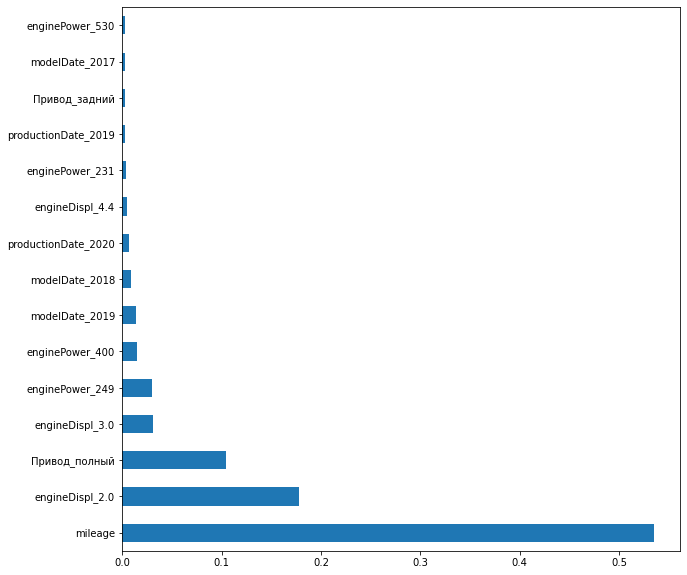

In [87]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Стакинг

In [88]:
# https://github.com/Dyakonov/ml_hacks/blob/master/dj_stacking.ipynb

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] = self.valid[:, t] + cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)

In [89]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression

knn1 = KNeighborsRegressor(n_neighbors=3)
knn2 = KNeighborsRegressor(n_neighbors=10)
rg0 = Ridge(alpha=0.01, random_state=random_state)
rg1 = Ridge(alpha=1.1, random_state=random_state)
rg2 = Ridge(alpha=100.1, random_state=random_state)
rf1 = RandomForestRegressor(n_estimators=100, max_depth=1, random_state=random_state)
rf2 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=random_state)
ext = ExtraTreesRegressor(n_estimators=300, n_jobs=-1, random_state=random_state)
lgr1 = LogisticRegression(C=0.001, penalty='l1', solver='saga', multi_class='ovr', max_iter=1000, random_state=42)
lgr2 = LogisticRegression(C=0.001, penalty='l2', random_state=42)
lgr3 = LogisticRegression(C=0.001, penalty='l2', solver='saga', multi_class='ovr', max_iter=1000, random_state=42)
cbr = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )

In [90]:
models = [knn1, knn2, rg1, rg2, rf1, rf2, ext, lgr1, lgr2, cbr]
ens_model = Ridge()

In [91]:
s2 = DjStacking(models, ens_model)
s2.fit(X_train, y_train, p=-1, cv=7)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	learn: 1.5897494	total: 5.15ms	remaining: 10.3s
1:	learn: 1.4726666	total: 9.5ms	remaining: 9.49s
2:	learn: 1.3545812	total: 14.2ms	remaining: 9.48s
3:	learn: 1.2614587	total: 18.1ms	remaining: 9.02s
4:	learn: 1.1696194	total: 21.9ms	remaining: 8.75s
5:	learn: 1.0920961	total: 24.6ms	remaining: 8.19s
6:	learn: 1.0131776	total: 27.3ms	remaining: 7.77s
7:	learn: 0.9438804	total: 30ms	remaining: 7.48s
8:	learn: 0.8763340	total: 32.9ms	remaining: 7.27s
9:	learn: 0.8173180	total: 35.6ms	remaining: 7.08s
10:	learn: 0.7652201	total: 38.4ms	remaining: 6.94s
11:	learn: 0.7154547	total: 41.1ms	remaining: 6.81s
12:	learn: 0.6771390	total: 43.7ms	remaining: 6.67s
13:	learn: 0.6424955	total: 46.5ms	remaining: 6.6s
14:	learn: 0.6122958	total: 49.5ms	remaining: 6.55s
15:	learn: 0.5784894	total: 52.2ms	remaining: 6.47s
16:	learn: 0.5469818	total: 54.9ms	remaining: 6.4s
17:	learn: 0.5161616	total: 57.7ms	remaining: 6.35s
18:	learn: 0.4938204	total: 60.4ms	remaining: 6.3s
19:	learn: 0.4733251	total: 

217:	learn: 0.1626526	total: 573ms	remaining: 4.69s
218:	learn: 0.1622242	total: 577ms	remaining: 4.69s
219:	learn: 0.1620955	total: 580ms	remaining: 4.69s
220:	learn: 0.1618499	total: 583ms	remaining: 4.69s
221:	learn: 0.1613743	total: 585ms	remaining: 4.69s
222:	learn: 0.1603878	total: 588ms	remaining: 4.68s
223:	learn: 0.1602498	total: 590ms	remaining: 4.68s
224:	learn: 0.1601606	total: 593ms	remaining: 4.67s
225:	learn: 0.1599436	total: 595ms	remaining: 4.67s
226:	learn: 0.1599229	total: 598ms	remaining: 4.67s
227:	learn: 0.1598396	total: 600ms	remaining: 4.66s
228:	learn: 0.1594344	total: 603ms	remaining: 4.66s
229:	learn: 0.1593370	total: 605ms	remaining: 4.66s
230:	learn: 0.1587279	total: 608ms	remaining: 4.65s
231:	learn: 0.1584727	total: 610ms	remaining: 4.65s
232:	learn: 0.1582282	total: 613ms	remaining: 4.64s
233:	learn: 0.1581056	total: 615ms	remaining: 4.64s
234:	learn: 0.1579326	total: 618ms	remaining: 4.64s
235:	learn: 0.1575668	total: 620ms	remaining: 4.64s
236:	learn: 

439:	learn: 0.1172543	total: 1.14s	remaining: 4.05s
440:	learn: 0.1171137	total: 1.15s	remaining: 4.05s
441:	learn: 0.1170191	total: 1.15s	remaining: 4.04s
442:	learn: 0.1169525	total: 1.15s	remaining: 4.04s
443:	learn: 0.1169013	total: 1.15s	remaining: 4.04s
444:	learn: 0.1168351	total: 1.16s	remaining: 4.04s
445:	learn: 0.1163037	total: 1.16s	remaining: 4.03s
446:	learn: 0.1159611	total: 1.16s	remaining: 4.03s
447:	learn: 0.1158442	total: 1.16s	remaining: 4.03s
448:	learn: 0.1156001	total: 1.16s	remaining: 4.02s
449:	learn: 0.1153753	total: 1.17s	remaining: 4.02s
450:	learn: 0.1152965	total: 1.17s	remaining: 4.02s
451:	learn: 0.1152075	total: 1.17s	remaining: 4.01s
452:	learn: 0.1150871	total: 1.17s	remaining: 4.01s
453:	learn: 0.1150189	total: 1.18s	remaining: 4.01s
454:	learn: 0.1149311	total: 1.18s	remaining: 4s
455:	learn: 0.1148546	total: 1.18s	remaining: 4s
456:	learn: 0.1146796	total: 1.18s	remaining: 4s
457:	learn: 0.1144554	total: 1.19s	remaining: 4s
458:	learn: 0.1144399	to

666:	learn: 0.0935216	total: 1.72s	remaining: 3.43s
667:	learn: 0.0934349	total: 1.72s	remaining: 3.43s
668:	learn: 0.0933581	total: 1.72s	remaining: 3.43s
669:	learn: 0.0932474	total: 1.73s	remaining: 3.43s
670:	learn: 0.0931038	total: 1.73s	remaining: 3.42s
671:	learn: 0.0930685	total: 1.73s	remaining: 3.42s
672:	learn: 0.0929047	total: 1.73s	remaining: 3.42s
673:	learn: 0.0928678	total: 1.74s	remaining: 3.42s
674:	learn: 0.0928332	total: 1.74s	remaining: 3.42s
675:	learn: 0.0927696	total: 1.74s	remaining: 3.41s
676:	learn: 0.0927253	total: 1.74s	remaining: 3.41s
677:	learn: 0.0926883	total: 1.75s	remaining: 3.41s
678:	learn: 0.0926234	total: 1.75s	remaining: 3.4s
679:	learn: 0.0926019	total: 1.75s	remaining: 3.4s
680:	learn: 0.0925342	total: 1.75s	remaining: 3.4s
681:	learn: 0.0922912	total: 1.76s	remaining: 3.4s
682:	learn: 0.0921209	total: 1.76s	remaining: 3.39s
683:	learn: 0.0920189	total: 1.76s	remaining: 3.39s
684:	learn: 0.0919984	total: 1.76s	remaining: 3.39s
685:	learn: 0.09

890:	learn: 0.0798037	total: 2.29s	remaining: 2.86s
891:	learn: 0.0797421	total: 2.3s	remaining: 2.85s
892:	learn: 0.0797317	total: 2.3s	remaining: 2.85s
893:	learn: 0.0797074	total: 2.3s	remaining: 2.85s
894:	learn: 0.0796761	total: 2.31s	remaining: 2.85s
895:	learn: 0.0795662	total: 2.31s	remaining: 2.84s
896:	learn: 0.0795182	total: 2.31s	remaining: 2.84s
897:	learn: 0.0794898	total: 2.31s	remaining: 2.84s
898:	learn: 0.0794441	total: 2.32s	remaining: 2.84s
899:	learn: 0.0794127	total: 2.32s	remaining: 2.83s
900:	learn: 0.0793994	total: 2.32s	remaining: 2.83s
901:	learn: 0.0793673	total: 2.32s	remaining: 2.83s
902:	learn: 0.0792698	total: 2.33s	remaining: 2.83s
903:	learn: 0.0791518	total: 2.33s	remaining: 2.82s
904:	learn: 0.0790768	total: 2.33s	remaining: 2.82s
905:	learn: 0.0790496	total: 2.33s	remaining: 2.82s
906:	learn: 0.0789665	total: 2.34s	remaining: 2.82s
907:	learn: 0.0789796	total: 2.34s	remaining: 2.82s
908:	learn: 0.0789717	total: 2.35s	remaining: 2.81s
909:	learn: 0.0

1086:	learn: 0.0711074	total: 2.87s	remaining: 2.41s
1087:	learn: 0.0710845	total: 2.87s	remaining: 2.41s
1088:	learn: 0.0710637	total: 2.88s	remaining: 2.41s
1089:	learn: 0.0710408	total: 2.88s	remaining: 2.4s
1090:	learn: 0.0710259	total: 2.88s	remaining: 2.4s
1091:	learn: 0.0710018	total: 2.88s	remaining: 2.4s
1092:	learn: 0.0709881	total: 2.89s	remaining: 2.4s
1093:	learn: 0.0709722	total: 2.89s	remaining: 2.39s
1094:	learn: 0.0708884	total: 2.89s	remaining: 2.39s
1095:	learn: 0.0708779	total: 2.89s	remaining: 2.39s
1096:	learn: 0.0707998	total: 2.9s	remaining: 2.38s
1097:	learn: 0.0707432	total: 2.9s	remaining: 2.38s
1098:	learn: 0.0706644	total: 2.9s	remaining: 2.38s
1099:	learn: 0.0706503	total: 2.9s	remaining: 2.38s
1100:	learn: 0.0706418	total: 2.91s	remaining: 2.37s
1101:	learn: 0.0706407	total: 2.91s	remaining: 2.37s
1102:	learn: 0.0706290	total: 2.91s	remaining: 2.37s
1103:	learn: 0.0705708	total: 2.91s	remaining: 2.37s
1104:	learn: 0.0705653	total: 2.92s	remaining: 2.36s
1

1311:	learn: 0.0647657	total: 3.44s	remaining: 1.81s
1312:	learn: 0.0647625	total: 3.45s	remaining: 1.8s
1313:	learn: 0.0647429	total: 3.45s	remaining: 1.8s
1314:	learn: 0.0647289	total: 3.45s	remaining: 1.8s
1315:	learn: 0.0646944	total: 3.46s	remaining: 1.8s
1316:	learn: 0.0646330	total: 3.46s	remaining: 1.79s
1317:	learn: 0.0645621	total: 3.46s	remaining: 1.79s
1318:	learn: 0.0644393	total: 3.46s	remaining: 1.79s
1319:	learn: 0.0644406	total: 3.46s	remaining: 1.78s
1320:	learn: 0.0643751	total: 3.47s	remaining: 1.78s
1321:	learn: 0.0643713	total: 3.47s	remaining: 1.78s
1322:	learn: 0.0643213	total: 3.47s	remaining: 1.78s
1323:	learn: 0.0642710	total: 3.48s	remaining: 1.77s
1324:	learn: 0.0642496	total: 3.48s	remaining: 1.77s
1325:	learn: 0.0642253	total: 3.48s	remaining: 1.77s
1326:	learn: 0.0642041	total: 3.48s	remaining: 1.77s
1327:	learn: 0.0641998	total: 3.48s	remaining: 1.76s
1328:	learn: 0.0641992	total: 3.49s	remaining: 1.76s
1329:	learn: 0.0641937	total: 3.49s	remaining: 1.7

1534:	learn: 0.0588976	total: 4.02s	remaining: 1.22s
1535:	learn: 0.0588840	total: 4.02s	remaining: 1.21s
1536:	learn: 0.0588531	total: 4.02s	remaining: 1.21s
1537:	learn: 0.0588325	total: 4.03s	remaining: 1.21s
1538:	learn: 0.0588086	total: 4.03s	remaining: 1.21s
1539:	learn: 0.0587934	total: 4.03s	remaining: 1.2s
1540:	learn: 0.0587748	total: 4.03s	remaining: 1.2s
1541:	learn: 0.0587724	total: 4.04s	remaining: 1.2s
1542:	learn: 0.0587537	total: 4.04s	remaining: 1.2s
1543:	learn: 0.0587198	total: 4.04s	remaining: 1.19s
1544:	learn: 0.0587046	total: 4.04s	remaining: 1.19s
1545:	learn: 0.0586408	total: 4.05s	remaining: 1.19s
1546:	learn: 0.0586098	total: 4.05s	remaining: 1.19s
1547:	learn: 0.0586085	total: 4.05s	remaining: 1.18s
1548:	learn: 0.0585883	total: 4.05s	remaining: 1.18s
1549:	learn: 0.0585788	total: 4.06s	remaining: 1.18s
1550:	learn: 0.0585825	total: 4.06s	remaining: 1.18s
1551:	learn: 0.0585420	total: 4.06s	remaining: 1.17s
1552:	learn: 0.0585046	total: 4.06s	remaining: 1.1

1760:	learn: 0.0534673	total: 4.59s	remaining: 623ms
1761:	learn: 0.0534341	total: 4.6s	remaining: 621ms
1762:	learn: 0.0534294	total: 4.6s	remaining: 618ms
1763:	learn: 0.0534200	total: 4.6s	remaining: 616ms
1764:	learn: 0.0534026	total: 4.6s	remaining: 613ms
1765:	learn: 0.0533793	total: 4.61s	remaining: 611ms
1766:	learn: 0.0533702	total: 4.61s	remaining: 608ms
1767:	learn: 0.0533577	total: 4.61s	remaining: 605ms
1768:	learn: 0.0533452	total: 4.62s	remaining: 603ms
1769:	learn: 0.0533219	total: 4.62s	remaining: 600ms
1770:	learn: 0.0533219	total: 4.62s	remaining: 598ms
1771:	learn: 0.0532887	total: 4.62s	remaining: 595ms
1772:	learn: 0.0532814	total: 4.63s	remaining: 592ms
1773:	learn: 0.0532524	total: 4.63s	remaining: 590ms
1774:	learn: 0.0532153	total: 4.63s	remaining: 587ms
1775:	learn: 0.0531974	total: 4.63s	remaining: 585ms
1776:	learn: 0.0531898	total: 4.64s	remaining: 582ms
1777:	learn: 0.0531326	total: 4.64s	remaining: 579ms
1778:	learn: 0.0531330	total: 4.64s	remaining: 577

1984:	learn: 0.0492426	total: 5.17s	remaining: 39ms
1985:	learn: 0.0492401	total: 5.17s	remaining: 36.4ms
1986:	learn: 0.0492303	total: 5.17s	remaining: 33.8ms
1987:	learn: 0.0492276	total: 5.17s	remaining: 31.2ms
1988:	learn: 0.0492185	total: 5.18s	remaining: 28.6ms
1989:	learn: 0.0492042	total: 5.18s	remaining: 26ms
1990:	learn: 0.0492012	total: 5.18s	remaining: 23.4ms
1991:	learn: 0.0491990	total: 5.18s	remaining: 20.8ms
1992:	learn: 0.0491891	total: 5.19s	remaining: 18.2ms
1993:	learn: 0.0491833	total: 5.19s	remaining: 15.6ms
1994:	learn: 0.0491558	total: 5.19s	remaining: 13ms
1995:	learn: 0.0490703	total: 5.19s	remaining: 10.4ms
1996:	learn: 0.0490593	total: 5.2s	remaining: 7.81ms
1997:	learn: 0.0490271	total: 5.2s	remaining: 5.2ms
1998:	learn: 0.0490101	total: 5.2s	remaining: 2.6ms
1999:	learn: 0.0489894	total: 5.2s	remaining: 0us


DjStacking(ens_model=Ridge(),
           models=[KNeighborsRegressor(n_neighbors=3),
                   KNeighborsRegressor(n_neighbors=10),
                   Ridge(alpha=1.1, random_state=42),
                   Ridge(alpha=100.1, random_state=42),
                   RandomForestRegressor(max_depth=1, random_state=42),
                   RandomForestRegressor(max_depth=5, random_state=42),
                   ExtraTreesRegressor(n_estimators=300, n_jobs=-1,
                                       random_state=42),
                   LogisticRegression(C=0.001, max_iter=1000, multi_class='ovr',
                                      penalty='l1', random_state=42,
                                      solver='saga'),
                   LogisticRegression(C=0.001, random_state=42),
                   <catboost.core.CatBoostRegressor object at 0x7f8d9ab27710>])

In [92]:
y_pred = s2.predict(X_test)
pr_metrics(y_test, y_pred)

mae = 307566.0 , mape = 16.59846063108378


In [93]:
s2 = DjStacking(models, ens_model)
s2.fit(X_train, y_train, p=-1, cv=5)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.5897494	total: 6.03ms	remaining: 12.1s
1:	learn: 1.4726666	total: 10.5ms	remaining: 10.5s
2:	learn: 1.3545812	total: 15.1ms	remaining: 10s
3:	learn: 1.2614587	total: 18.9ms	remaining: 9.44s
4:	learn: 1.1696194	total: 22.7ms	remaining: 9.06s
5:	learn: 1.0920961	total: 26ms	remaining: 8.63s
6:	learn: 1.0131776	total: 35ms	remaining: 9.97s
7:	learn: 0.9438804	total: 39ms	remaining: 9.71s
8:	learn: 0.8763340	total: 42.8ms	remaining: 9.47s
9:	learn: 0.8173180	total: 46.9ms	remaining: 9.33s
10:	learn: 0.7652201	total: 51ms	remaining: 9.22s
11:	learn: 0.7154547	total: 55.1ms	remaining: 9.13s
12:	learn: 0.6771390	total: 57.9ms	remaining: 8.86s
13:	learn: 0.6424955	total: 61.4ms	remaining: 8.71s
14:	learn: 0.6122958	total: 65ms	remaining: 8.61s
15:	learn: 0.5784894	total: 68.3ms	remaining: 8.47s
16:	learn: 0.5469818	total: 71.8ms	remaining: 8.38s
17:	learn: 0.5161616	total: 75.5ms	remaining: 8.31s
18:	learn: 0.4938204	total: 79ms	remaining: 8.23s
19:	learn: 0.4733251	total: 82.2ms	r

190:	learn: 0.1718793	total: 583ms	remaining: 5.53s
191:	learn: 0.1716650	total: 586ms	remaining: 5.52s
192:	learn: 0.1715689	total: 588ms	remaining: 5.51s
193:	learn: 0.1712185	total: 591ms	remaining: 5.5s
194:	learn: 0.1713556	total: 594ms	remaining: 5.49s
195:	learn: 0.1710306	total: 596ms	remaining: 5.49s
196:	learn: 0.1705989	total: 599ms	remaining: 5.48s
197:	learn: 0.1701063	total: 601ms	remaining: 5.47s
198:	learn: 0.1697698	total: 604ms	remaining: 5.47s
199:	learn: 0.1696521	total: 607ms	remaining: 5.46s
200:	learn: 0.1691813	total: 609ms	remaining: 5.45s
201:	learn: 0.1678300	total: 612ms	remaining: 5.45s
202:	learn: 0.1677261	total: 614ms	remaining: 5.44s
203:	learn: 0.1673858	total: 617ms	remaining: 5.43s
204:	learn: 0.1670185	total: 620ms	remaining: 5.42s
205:	learn: 0.1663085	total: 622ms	remaining: 5.42s
206:	learn: 0.1659735	total: 625ms	remaining: 5.41s
207:	learn: 0.1657145	total: 627ms	remaining: 5.4s
208:	learn: 0.1655760	total: 630ms	remaining: 5.4s
209:	learn: 0.1

412:	learn: 0.1205958	total: 1.15s	remaining: 4.43s
413:	learn: 0.1205055	total: 1.16s	remaining: 4.43s
414:	learn: 0.1205193	total: 1.16s	remaining: 4.42s
415:	learn: 0.1204625	total: 1.16s	remaining: 4.42s
416:	learn: 0.1202183	total: 1.16s	remaining: 4.41s
417:	learn: 0.1200969	total: 1.17s	remaining: 4.41s
418:	learn: 0.1200008	total: 1.17s	remaining: 4.41s
419:	learn: 0.1199154	total: 1.17s	remaining: 4.4s
420:	learn: 0.1197074	total: 1.17s	remaining: 4.4s
421:	learn: 0.1194235	total: 1.18s	remaining: 4.39s
422:	learn: 0.1193416	total: 1.18s	remaining: 4.39s
423:	learn: 0.1189440	total: 1.18s	remaining: 4.39s
424:	learn: 0.1188991	total: 1.18s	remaining: 4.38s
425:	learn: 0.1187202	total: 1.19s	remaining: 4.38s
426:	learn: 0.1186933	total: 1.19s	remaining: 4.38s
427:	learn: 0.1185929	total: 1.19s	remaining: 4.37s
428:	learn: 0.1185290	total: 1.19s	remaining: 4.37s
429:	learn: 0.1184808	total: 1.2s	remaining: 4.36s
430:	learn: 0.1184151	total: 1.2s	remaining: 4.36s
431:	learn: 0.11

640:	learn: 0.0953938	total: 1.72s	remaining: 3.66s
641:	learn: 0.0953673	total: 1.73s	remaining: 3.66s
642:	learn: 0.0951992	total: 1.73s	remaining: 3.65s
643:	learn: 0.0950544	total: 1.73s	remaining: 3.65s
644:	learn: 0.0949956	total: 1.74s	remaining: 3.65s
645:	learn: 0.0949292	total: 1.74s	remaining: 3.65s
646:	learn: 0.0948728	total: 1.75s	remaining: 3.65s
647:	learn: 0.0948372	total: 1.75s	remaining: 3.65s
648:	learn: 0.0948166	total: 1.75s	remaining: 3.65s
649:	learn: 0.0947826	total: 1.75s	remaining: 3.64s
650:	learn: 0.0946060	total: 1.76s	remaining: 3.64s
651:	learn: 0.0945640	total: 1.76s	remaining: 3.64s
652:	learn: 0.0944902	total: 1.76s	remaining: 3.63s
653:	learn: 0.0943999	total: 1.76s	remaining: 3.63s
654:	learn: 0.0943952	total: 1.77s	remaining: 3.63s
655:	learn: 0.0942923	total: 1.77s	remaining: 3.63s
656:	learn: 0.0943055	total: 1.77s	remaining: 3.63s
657:	learn: 0.0941666	total: 1.78s	remaining: 3.63s
658:	learn: 0.0940650	total: 1.78s	remaining: 3.62s
659:	learn: 

858:	learn: 0.0815011	total: 2.29s	remaining: 3.05s
859:	learn: 0.0814433	total: 2.3s	remaining: 3.05s
860:	learn: 0.0814252	total: 2.3s	remaining: 3.04s
861:	learn: 0.0814114	total: 2.3s	remaining: 3.04s
862:	learn: 0.0812926	total: 2.31s	remaining: 3.04s
863:	learn: 0.0811728	total: 2.31s	remaining: 3.04s
864:	learn: 0.0811703	total: 2.31s	remaining: 3.03s
865:	learn: 0.0811462	total: 2.31s	remaining: 3.03s
866:	learn: 0.0811085	total: 2.32s	remaining: 3.03s
867:	learn: 0.0810432	total: 2.32s	remaining: 3.02s
868:	learn: 0.0809772	total: 2.32s	remaining: 3.02s
869:	learn: 0.0809328	total: 2.32s	remaining: 3.02s
870:	learn: 0.0809047	total: 2.33s	remaining: 3.02s
871:	learn: 0.0808371	total: 2.33s	remaining: 3.01s
872:	learn: 0.0808120	total: 2.33s	remaining: 3.01s
873:	learn: 0.0807280	total: 2.33s	remaining: 3.01s
874:	learn: 0.0806920	total: 2.34s	remaining: 3s
875:	learn: 0.0806494	total: 2.34s	remaining: 3s
876:	learn: 0.0805475	total: 2.34s	remaining: 3s
877:	learn: 0.0805039	to

1079:	learn: 0.0714082	total: 2.87s	remaining: 2.44s
1080:	learn: 0.0713709	total: 2.87s	remaining: 2.44s
1081:	learn: 0.0713549	total: 2.88s	remaining: 2.44s
1082:	learn: 0.0712841	total: 2.88s	remaining: 2.44s
1083:	learn: 0.0712278	total: 2.88s	remaining: 2.44s
1084:	learn: 0.0711690	total: 2.88s	remaining: 2.43s
1085:	learn: 0.0711578	total: 2.89s	remaining: 2.43s
1086:	learn: 0.0711074	total: 2.89s	remaining: 2.43s
1087:	learn: 0.0710845	total: 2.89s	remaining: 2.42s
1088:	learn: 0.0710637	total: 2.89s	remaining: 2.42s
1089:	learn: 0.0710408	total: 2.9s	remaining: 2.42s
1090:	learn: 0.0710259	total: 2.9s	remaining: 2.42s
1091:	learn: 0.0710018	total: 2.9s	remaining: 2.41s
1092:	learn: 0.0709881	total: 2.9s	remaining: 2.41s
1093:	learn: 0.0709722	total: 2.91s	remaining: 2.41s
1094:	learn: 0.0708884	total: 2.91s	remaining: 2.4s
1095:	learn: 0.0708779	total: 2.91s	remaining: 2.4s
1096:	learn: 0.0707998	total: 2.91s	remaining: 2.4s
1097:	learn: 0.0707432	total: 2.92s	remaining: 2.4s
1

1305:	learn: 0.0649895	total: 3.44s	remaining: 1.83s
1306:	learn: 0.0649529	total: 3.44s	remaining: 1.83s
1307:	learn: 0.0648839	total: 3.45s	remaining: 1.82s
1308:	learn: 0.0648549	total: 3.45s	remaining: 1.82s
1309:	learn: 0.0648386	total: 3.45s	remaining: 1.82s
1310:	learn: 0.0647771	total: 3.46s	remaining: 1.82s
1311:	learn: 0.0647657	total: 3.46s	remaining: 1.81s
1312:	learn: 0.0647625	total: 3.46s	remaining: 1.81s
1313:	learn: 0.0647429	total: 3.46s	remaining: 1.81s
1314:	learn: 0.0647289	total: 3.47s	remaining: 1.8s
1315:	learn: 0.0646944	total: 3.47s	remaining: 1.8s
1316:	learn: 0.0646330	total: 3.47s	remaining: 1.8s
1317:	learn: 0.0645621	total: 3.47s	remaining: 1.8s
1318:	learn: 0.0644393	total: 3.48s	remaining: 1.79s
1319:	learn: 0.0644406	total: 3.48s	remaining: 1.79s
1320:	learn: 0.0643751	total: 3.48s	remaining: 1.79s
1321:	learn: 0.0643713	total: 3.48s	remaining: 1.79s
1322:	learn: 0.0643213	total: 3.49s	remaining: 1.78s
1323:	learn: 0.0642710	total: 3.49s	remaining: 1.7

1528:	learn: 0.0590276	total: 4.01s	remaining: 1.24s
1529:	learn: 0.0590092	total: 4.01s	remaining: 1.23s
1530:	learn: 0.0590020	total: 4.02s	remaining: 1.23s
1531:	learn: 0.0589838	total: 4.02s	remaining: 1.23s
1532:	learn: 0.0589580	total: 4.02s	remaining: 1.23s
1533:	learn: 0.0589121	total: 4.02s	remaining: 1.22s
1534:	learn: 0.0588976	total: 4.03s	remaining: 1.22s
1535:	learn: 0.0588840	total: 4.03s	remaining: 1.22s
1536:	learn: 0.0588531	total: 4.03s	remaining: 1.21s
1537:	learn: 0.0588325	total: 4.03s	remaining: 1.21s
1538:	learn: 0.0588086	total: 4.04s	remaining: 1.21s
1539:	learn: 0.0587934	total: 4.04s	remaining: 1.21s
1540:	learn: 0.0587748	total: 4.04s	remaining: 1.2s
1541:	learn: 0.0587724	total: 4.04s	remaining: 1.2s
1542:	learn: 0.0587537	total: 4.05s	remaining: 1.2s
1543:	learn: 0.0587198	total: 4.05s	remaining: 1.2s
1544:	learn: 0.0587046	total: 4.05s	remaining: 1.19s
1545:	learn: 0.0586408	total: 4.05s	remaining: 1.19s
1546:	learn: 0.0586098	total: 4.06s	remaining: 1.1

1737:	learn: 0.0538536	total: 4.58s	remaining: 690ms
1738:	learn: 0.0538337	total: 4.58s	remaining: 688ms
1739:	learn: 0.0538229	total: 4.58s	remaining: 685ms
1740:	learn: 0.0538076	total: 4.59s	remaining: 683ms
1741:	learn: 0.0537837	total: 4.59s	remaining: 680ms
1742:	learn: 0.0537692	total: 4.59s	remaining: 677ms
1743:	learn: 0.0537572	total: 4.6s	remaining: 675ms
1744:	learn: 0.0537484	total: 4.6s	remaining: 672ms
1745:	learn: 0.0537287	total: 4.6s	remaining: 669ms
1746:	learn: 0.0537025	total: 4.6s	remaining: 667ms
1747:	learn: 0.0536767	total: 4.61s	remaining: 664ms
1748:	learn: 0.0536504	total: 4.61s	remaining: 662ms
1749:	learn: 0.0536312	total: 4.61s	remaining: 659ms
1750:	learn: 0.0536224	total: 4.62s	remaining: 656ms
1751:	learn: 0.0535734	total: 4.62s	remaining: 654ms
1752:	learn: 0.0535619	total: 4.62s	remaining: 651ms
1753:	learn: 0.0535474	total: 4.62s	remaining: 648ms
1754:	learn: 0.0535330	total: 4.63s	remaining: 646ms
1755:	learn: 0.0535313	total: 4.63s	remaining: 643

1958:	learn: 0.0497904	total: 5.15s	remaining: 108ms
1959:	learn: 0.0497490	total: 5.15s	remaining: 105ms
1960:	learn: 0.0497054	total: 5.15s	remaining: 103ms
1961:	learn: 0.0496340	total: 5.16s	remaining: 99.9ms
1962:	learn: 0.0496023	total: 5.16s	remaining: 97.3ms
1963:	learn: 0.0495747	total: 5.16s	remaining: 94.6ms
1964:	learn: 0.0495753	total: 5.16s	remaining: 92ms
1965:	learn: 0.0495743	total: 5.17s	remaining: 89.4ms
1966:	learn: 0.0495548	total: 5.17s	remaining: 86.7ms
1967:	learn: 0.0495453	total: 5.17s	remaining: 84.1ms
1968:	learn: 0.0495464	total: 5.17s	remaining: 81.5ms
1969:	learn: 0.0495327	total: 5.18s	remaining: 78.8ms
1970:	learn: 0.0494901	total: 5.18s	remaining: 76.2ms
1971:	learn: 0.0494562	total: 5.18s	remaining: 73.6ms
1972:	learn: 0.0494079	total: 5.18s	remaining: 71ms
1973:	learn: 0.0493815	total: 5.19s	remaining: 68.3ms
1974:	learn: 0.0493810	total: 5.19s	remaining: 65.7ms
1975:	learn: 0.0493613	total: 5.19s	remaining: 63.1ms
1976:	learn: 0.0493422	total: 5.2s	

DjStacking(ens_model=Ridge(),
           models=[KNeighborsRegressor(n_neighbors=3),
                   KNeighborsRegressor(n_neighbors=10),
                   Ridge(alpha=1.1, random_state=42),
                   Ridge(alpha=100.1, random_state=42),
                   RandomForestRegressor(max_depth=1, random_state=42),
                   RandomForestRegressor(max_depth=5, random_state=42),
                   ExtraTreesRegressor(n_estimators=300, n_jobs=-1,
                                       random_state=42),
                   LogisticRegression(C=0.001, max_iter=1000, multi_class='ovr',
                                      penalty='l1', random_state=42,
                                      solver='saga'),
                   LogisticRegression(C=0.001, random_state=42),
                   <catboost.core.CatBoostRegressor object at 0x7f8d9ab27710>])

In [94]:
y_pred = s2.predict(X_test)
pr_metrics(y_test, y_pred)

mae = 307674.0 , mape = 16.207037848181216


In [95]:
best_model = s2

## Submission

In [96]:
test_data = df[df['sample'] == 0].drop(columns=['price', 'sample'])

In [97]:
test_data.sample(10)

,mileage,Руль,ПТС,eq_Система распознавания дорожных знаков,eq_Круиз-контроль,eq_Система стабилизации (ESP),eq_Парктроник передний,eq_Подушка безопасности для защиты коленей водителя,eq_Подушка безопасности водителя,eq_Усилитель руля,...,engineDispl_3.9,engineDispl_4.0,engineDispl_4.4,engineDispl_4.6,engineDispl_4.8,engineDispl_4.9,engineDispl_5.0,engineDispl_5.4,engineDispl_6.0,engineDispl_6.6
3159,0.599698,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2501,0.310166,0,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1605,-0.880133,0,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
300,0.679684,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2973,0.503187,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3076,-0.215281,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2887,0.385230,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
591,-1.004525,0,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2608,-0.646620,0,1,0,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1905,-0.536984,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
test_data.shape, df_test.shape, X_test.shape

((3837, 415), (3837, 25), (1083, 415))

In [99]:
sample_submission
sample_submission.dtypes

,id,price
0,0,5299000.0
1,1,1580000.0
2,2,2000000.0
3,3,2199000.0
4,4,935000.0
...,...,...
3832,3832,969000.0
3833,3833,1750000.0
3834,3834,1100000.0
3835,3835,2939000.0


id         int64
price    float64
dtype: object

In [100]:
predict_submission = best_model.predict(test_data)

In [101]:
# submit = df_test[['id']]
submit = df_test.loc[:, ['id']]
# submit = pd.DataFrame(df_test[df['sample'] == 0]['id'])
predict_submission.shape
submit

(3837,)

,id
0,0
1,1
2,2
3,3
4,4
...,...
3832,3832
3833,3833
3834,3834
3835,3835


In [102]:
submit['price'] = predict_submission

In [103]:
submit
submit.dtypes

,id,price
0,0,1.896113e+06
1,1,2.691985e+06
2,2,1.406027e+06
3,3,2.714625e+06
4,4,5.312900e+06
...,...,...
3832,3832,1.310572e+06
3833,3833,3.002364e+06
3834,3834,7.721960e+05
3835,3835,1.171024e+06


id         Int64
price    float64
dtype: object

In [104]:
submit.sample(10)

,id,price
2019,2019,2.081775e+06
19,19,1.021324e+06
834,834,2.756168e+06
3557,3557,3.060953e+06
1695,1695,1.130881e+06
3186,3186,1.789910e+06
336,336,3.047101e+05
2367,2367,6.752160e+05
1096,1096,7.759971e+05
2486,2486,2.732658e+06


In [105]:
submit.to_csv('submission.csv', index=False)

## Заключение

### Итог

Лучший результат дал стакинг с числом фолдов 5

### Что можно улучшить

- Попробовать другой набор моделей для стакинга.
- Векторизировать и использовать текст описания
- Добавить пераметры на основании "name"
- Попробовать добавление в трейн данных с другим брендом